# Bibliotecas

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Funções definidas

In [3]:
def ler_csv(caminho):
    with open(caminho, encoding="utf8", errors="ignore") as f:
        return pd.read_csv(f, sep=";")
def mudarvalor(coluna):
    for index in range(0, coluna.nunique()):
        coluna.replace({coluna.unique()[index]: index}, inplace=True)


# Arquivos

In [4]:
paths = ['dados\cda_fi_BLC_1_202112.csv',
         'dados\cda_fi_BLC_2_202112.csv',
         'dados\cda_fi_BLC_3_202112.csv',
         'dados\cda_fi_BLC_4_202112.csv',
         'dados\cda_fi_BLC_5_202112.csv',
         'dados\cda_fi_BLC_6_202112.csv',
         'dados\cda_fi_BLC_7_202112.csv',
         'dados\cda_fi_BLC_8_202112.csv',
         'dados\cda_fi_CONFID_202112.csv',
         'dados\cda_fi_PL_202112.csv']

In [5]:
fundo0 = ler_csv(paths[0])
fundo1 = ler_csv(paths[1])
fundo2 = ler_csv(paths[2])
fundo3 = ler_csv(paths[3])
fundo4 = ler_csv(paths[4])
fundo5 = ler_csv(paths[5])
fundo6 = ler_csv(paths[6])
fundo7 = ler_csv(paths[7])
fundo8 = ler_csv(paths[8])
fundo9 = ler_csv(paths[9])

<ipython-input-5-1c903f831f0c>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo1 = ler_csv(paths[1])
<ipython-input-5-1c903f831f0c>:4: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo3 = ler_csv(paths[3])
<ipython-input-5-1c903f831f0c>:8: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo7 = ler_csv(paths[7])


In [6]:
fundos = [fundo0, fundo1, fundo2, fundo3, fundo4, fundo5, fundo6, fundo7, fundo8, fundo9]
df = pd.concat(fundos, axis=0, ignore_index=True)
df_s = df[['CNPJ_FUNDO', 'TP_APLIC', 'TP_ATIVO', 'VL_MERC_POS_FINAL']]


# Data Clean

Para a limpeza do dataset, irei retirar as colunas que não entregam informações relevantes para a classificação. As colunas removidas foram: 
- A coluna de Data de competência do documento: já que esta coluna apenas indica a competência do relatório emitido (31-12-2021)


In [7]:
df_s

,CNPJ_FUNDO,TP_APLIC,TP_ATIVO,VL_MERC_POS_FINAL
0,02.010.153/0001-45,Operaes Compromissadas,Ttulo pblico federal,2353628.12
1,02.010.153/0001-45,Ttulos Pblicos,Ttulo pblico federal,405552.65
2,02.010.153/0001-45,Ttulos Pblicos,Ttulo pblico federal,3823829.28
3,02.010.153/0001-45,Ttulos Pblicos,Ttulo pblico federal,7161655.06
4,02.010.153/0001-45,Ttulos Pblicos,Ttulo pblico federal,26759.24
...,...,...,...,...
435866,04.573.842/0001-93,NaN,NaN,NaN
435867,04.573.850/0001-30,NaN,NaN,NaN
435868,04.602.186/0001-00,NaN,NaN,NaN
435869,04.609.196/0001-77,NaN,NaN,NaN


Para avaliar a correlação entre as features do dataset simplificado proposto, as features precisaram passar por um processo de numeração dos dados já que a correlação é realizada apenas com features numéricas.

In [18]:
for col in df_s.columns[1:]:
    mudarvalor(df_s[col])
df_s.to_csv(path_or_buf='dados\df_s.csv', sep=';')


C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


IndexError: index 324412 is out of bounds for axis 0 with size 324412

In [21]:
df_s.to_csv(path_or_buf='dados\df_s.csv', sep=';')

In [22]:
g = df.columns.to_series().groupby(df.dtypes).groups
g
{k.name: v for k, v in g.items()}

{'float64': Index(['TP_APLIC', 'TP_ATIVO', 'QT_VENDA_NEGOC', 'VL_VENDA_NEGOC',
        'QT_AQUIS_NEGOC', 'VL_AQUIS_NEGOC', 'QT_POS_FINAL', 'VL_MERC_POS_FINAL',
        'VL_CUSTO_POS_FINAL', 'CD_SELIC', 'PR_INDEXADOR_POSFX',
        'PR_CUPOM_POSFX', 'PR_TAXA_PREFX', 'QT_ATIVO_EXTERIOR',
        'VL_ATIVO_EXTERIOR', 'VL_PATRIM_LIQ'],
       dtype='object'),
 'object': Index(['TP_FUNDO', 'CNPJ_FUNDO', 'DENOM_SOCIAL', 'DT_COMPTC', 'EMISSOR_LIGADO',
        'TP_NEGOC', 'DT_CONFID_APLIC', 'TP_TITPUB', 'CD_ISIN', 'DT_EMISSAO',
        'DT_VENC', 'CNPJ_FUNDO_COTA', 'NM_FUNDO_COTA', 'CD_SWAP', 'DS_SWAP',
        'CD_ATIVO', 'DS_ATIVO', 'DT_INI_VIGENCIA', 'DT_FIM_VIGENCIA',
        'CNPJ_EMISSOR', 'EMISSOR', 'TITULO_POSFX', 'CD_INDEXADOR_POSFX',
        'DS_INDEXADOR_POSFX', 'RISCO_EMISSOR', 'AG_RISCO', 'DT_RISCO',
        'GRAU_RISCO', 'PF_PJ_EMISSOR', 'CPF_CNPJ_EMISSOR', 'TITULO_CETIP',
        'TITULO_GARANTIA', 'CNPJ_INSTITUICAO_FINANC_COOBR', 'INVEST_COLETIVO',
        'INVEST_COLETIVO_GES

In [23]:
df_mudar = df.drop(['TP_APLIC', 'TP_ATIVO', 'QT_VENDA_NEGOC', 'VL_VENDA_NEGOC',
              'QT_AQUIS_NEGOC', 'VL_AQUIS_NEGOC', 'QT_POS_FINAL', 'VL_MERC_POS_FINAL',
              'VL_CUSTO_POS_FINAL', 'CD_SELIC', 'PR_INDEXADOR_POSFX',
              'PR_CUPOM_POSFX', 'PR_TAXA_PREFX', 'QT_ATIVO_EXTERIOR',
              'VL_ATIVO_EXTERIOR', 'VL_PATRIM_LIQ'], axis=1)


In [29]:
df_norm = df.drop(['TP_FUNDO', 'CNPJ_FUNDO', 'DENOM_SOCIAL', 'DT_COMPTC', 'EMISSOR_LIGADO',
                   'TP_NEGOC', 'DT_CONFID_APLIC', 'TP_TITPUB', 'CD_ISIN', 'DT_EMISSAO',
                   'DT_VENC', 'CNPJ_FUNDO_COTA', 'NM_FUNDO_COTA', 'CD_SWAP', 'DS_SWAP',
                   'CD_ATIVO', 'DS_ATIVO', 'DT_INI_VIGENCIA', 'DT_FIM_VIGENCIA',
                   'CNPJ_EMISSOR', 'EMISSOR', 'TITULO_POSFX', 'CD_INDEXADOR_POSFX',
                   'DS_INDEXADOR_POSFX', 'RISCO_EMISSOR', 'AG_RISCO', 'DT_RISCO',
                   'GRAU_RISCO', 'PF_PJ_EMISSOR', 'CPF_CNPJ_EMISSOR', 'TITULO_CETIP',
                   'TITULO_GARANTIA', 'CNPJ_INSTITUICAO_FINANC_COOBR', 'INVEST_COLETIVO',
                   'INVEST_COLETIVO_GESTOR', 'CD_PAIS', 'PAIS', 'CD_BV_MERC', 'BV_MERC',
                   'CD_ATIVO_BV_MERC', 'DS_ATIVO_EXTERIOR'], axis=1)


In [32]:
scaler = MinMaxScaler()
scaler.fit(df_norm)


MinMaxScaler()

In [34]:
for col in df_mudar.columns[1:]:
    mudarvalor(df_mudar[col])
df2 = pd.concat([df_mudar, df_norm], axis=0, ignore_index=True)


C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)


<AxesSubplot:>

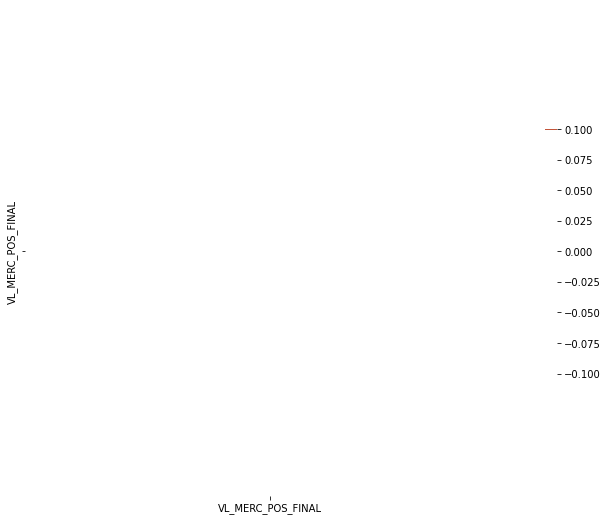

In [114]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [94]:
corr

,QT_VENDA_NEGOC,VL_VENDA_NEGOC,QT_AQUIS_NEGOC,VL_AQUIS_NEGOC,QT_POS_FINAL,VL_MERC_POS_FINAL,VL_CUSTO_POS_FINAL,CD_SELIC,PR_INDEXADOR_POSFX,PR_CUPOM_POSFX,PR_TAXA_PREFX,QT_ATIVO_EXTERIOR,VL_ATIVO_EXTERIOR,VL_PATRIM_LIQ
QT_VENDA_NEGOC,1.000000,0.000776,0.516253,0.000695,0.002091,0.197311,0.109395,-0.039654,-0.033879,-0.025519,-0.051921,NaN,NaN,NaN
VL_VENDA_NEGOC,0.000776,1.000000,0.000381,0.000006,-0.000023,0.000290,0.042123,-0.040138,-0.034774,-0.025345,-0.051921,NaN,NaN,NaN
QT_AQUIS_NEGOC,0.516253,0.000381,1.000000,0.000367,0.003123,0.107114,0.095278,-0.043835,-0.032065,-0.024491,-0.082296,NaN,NaN,NaN
VL_AQUIS_NEGOC,0.000695,0.000006,0.000367,1.000000,-0.000023,0.000506,0.203225,-0.050357,-0.032284,-0.025307,-0.075098,NaN,NaN,NaN
QT_POS_FINAL,0.002091,-0.000023,0.003123,-0.000023,1.000000,0.015838,0.544475,-0.021614,-0.003623,-0.001456,-0.072997,1.000000,-0.005044,NaN
VL_MERC_POS_FINAL,0.197311,0.000290,0.107114,0.000506,0.015838,1.000000,0.913831,-0.006335,-0.011153,-0.018644,0.009350,-0.005044,1.000000,NaN
VL_CUSTO_POS_FINAL,0.109395,0.042123,0.095278,0.203225,0.544475,0.913831,1.000000,0.580292,NaN,NaN,NaN,NaN,NaN,NaN
CD_SELIC,-0.039654,-0.040138,-0.043835,-0.050357,-0.021614,-0.006335,0.580292,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
PR_INDEXADOR_POSFX,-0.033879,-0.034774,-0.032065,-0.032284,-0.003623,-0.011153,NaN,NaN,1.000000,0.142164,NaN,NaN,NaN,NaN
PR_CUPOM_POSFX,-0.025519,-0.025345,-0.024491,-0.025307,-0.001456,-0.018644,NaN,NaN,0.142164,1.000000,NaN,NaN,NaN,NaN
